In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly.express as px

In [4]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/marketing_campaign.csv', sep='\t')


df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)


df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
today = df.Dt_Customer.max()
df['days_lifetime'] = (today - df.Dt_Customer).dt.days
df['years_customer'] = df.Year_Birth.apply(lambda x: today.year - x)


df_education = pd.get_dummies(df.Education, prefix='education').astype(int)
df = pd.concat([df, df_education], axis=1)


marital_status_map = {'Alone': 'Single', 'Absurd': 'Else', 'YOLO': 'Else'}
df['Marital_Status_clean'] = df.Marital_Status.map(marital_status_map)
df_ms = pd.get_dummies(df.Marital_Status_clean, prefix='marital').astype(int)
df = pd.concat([df, df_ms], axis=1)


df.Income = df.Income.astype(int)
df = df[df.Income != 666666]


X = df.drop(['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Marital_Status_clean'], axis=1)
X.reset_index(drop=True, inplace=True)

## Clustering

In [6]:
features = ['Income', 'Recency', 'NumStorePurchases', 'NumDealsPurchases', 'days_lifetime', 'years_customer', 'NumWebVisitsMonth']

X_sel = X[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

In [7]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_scaled)


df_viz = df.copy()
df_viz['cluster'] = clusters

In [8]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['cluster'] = clusters
pca_df['customer_id'] = df['ID'].values
for col in features:
    pca_df[col] = X_sel[col].values


fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='cluster',
    hover_data=['customer_id'] + features,
    title='Clusters in the space of the first three principal components'
)
fig.show()

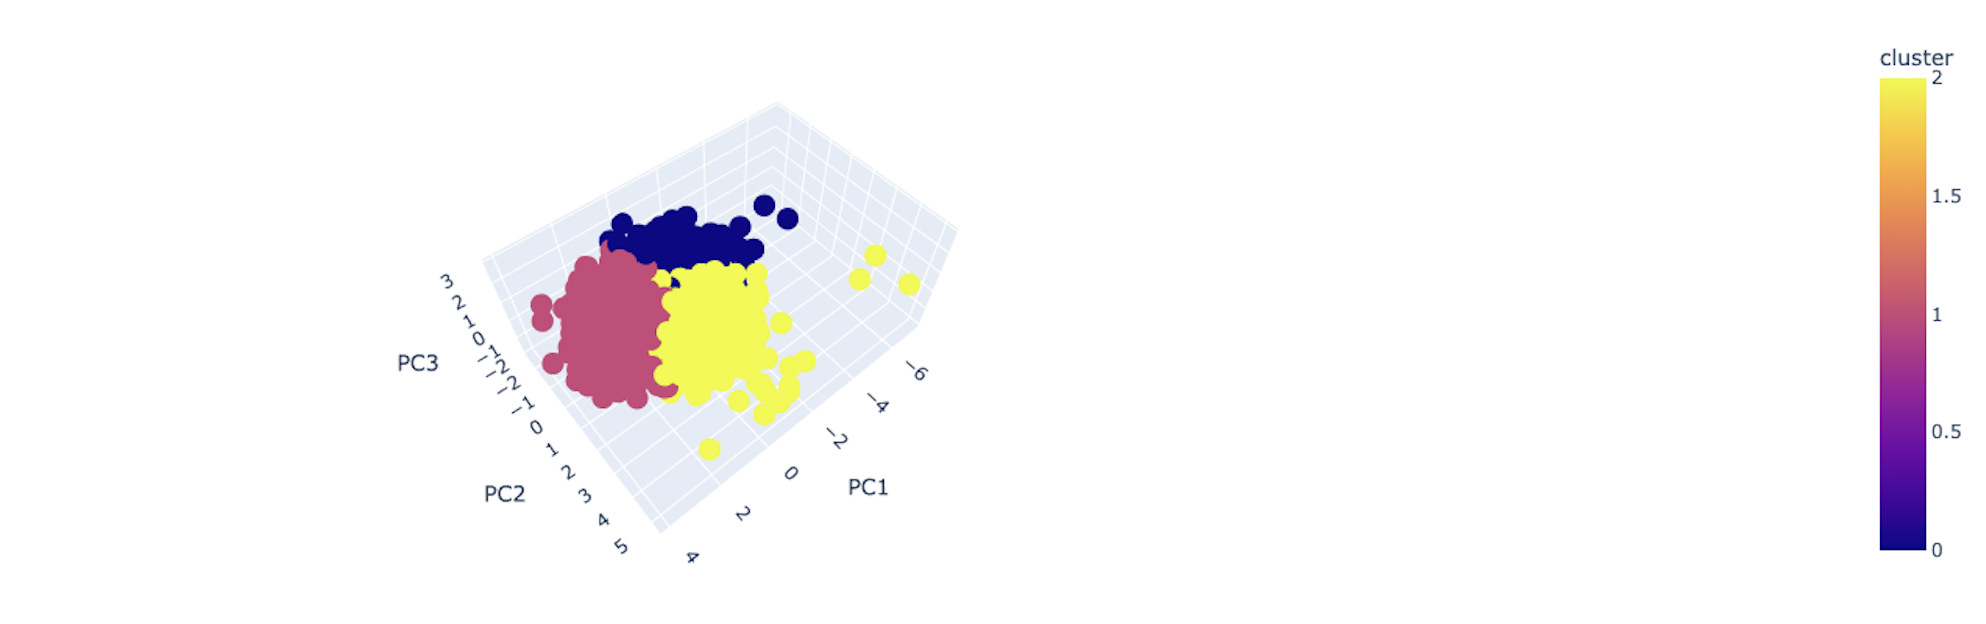

**Overall, the clustering looks quite clear, with a logical structure that confirms the presence of different types of customers.**

## Analysis

In [9]:
explained = pca.explained_variance_ratio_
print('Explained variance ratio (PC1..PC3):', explained)

cum_explained = explained.cumsum()
print('Cumulative explained variance (PC1..PC3):', cum_explained)

Explained variance ratio (PC1..PC3): [0.31847333 0.19659128 0.1433869 ]
Cumulative explained variance (PC1..PC3): [0.31847333 0.51506461 0.6584515 ]


**Explained variance of the principal components:**
*   PC1 — 31.8% of the data variation
*   PC2 — 19.7 %
*   PC3 — 14.3 %

**Together, the three principal components explain about 65.8% of the total variance. This level is acceptable for visualization and further interpretation of the clusters, although some portion of the variance is still lost.**

In [10]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=['PC1', 'PC2', 'PC3']
)

print("Loadings:")
display(loadings)

for pc in ['PC1', 'PC2', 'PC3']:
    print(f"\nТОП {pc}:")
    display(loadings[pc].abs().sort_values(ascending=False).head(5))

Loadings (вплив ознак на головні компоненти):


,PC1,PC2,PC3
Income,0.584238,0.165255,-0.044491
Recency,0.010075,0.036810,0.975799
NumStorePurchases,0.488621,0.384659,-0.080566
NumDealsPurchases,-0.198661,0.608119,-0.034808
days_lifetime,-0.132683,0.602585,-0.022223
years_customer,0.189393,0.208946,0.193368
NumWebVisitsMonth,-0.571728,0.216329,-0.015815



ТОП-ознаки для PC1:


,PC1
Income,0.584238
NumWebVisitsMonth,0.571728
NumStorePurchases,0.488621
NumDealsPurchases,0.198661
years_customer,0.189393



ТОП-ознаки для PC2:


,PC2
NumDealsPurchases,0.608119
days_lifetime,0.602585
NumStorePurchases,0.384659
NumWebVisitsMonth,0.216329
years_customer,0.208946



ТОП-ознаки для PC3:


,PC3
Recency,0.975799
years_customer,0.193368
NumStorePurchases,0.080566
Income,0.044491
NumDealsPurchases,0.034808


* **In PC1, the largest contributions come from: Income (+0.58), NumWebVisitsMonth (−0.57), and NumStorePurchases (+0.49). The first component reflects purchasing power and buying activity.**

* **In PC2, the main contributions are: NumDealsPurchases (+0.61), days_lifetime (+0.60), and NumStorePurchases (+0.38). This indicates that PC2 is related to the customer’s interaction history with the company — how long they have been registered and how frequently they use discount offers.**

* **In PC3, the dominant variable is Recency (+0.98), meaning the number of days since the last purchase. Thus, PC3 primarily represents the recency of a customer’s activity: the higher the value of PC3, the longer it has been since the last purchase.**

In [11]:
features_wo_income = [f for f in features if f != 'Income']

X_sel_wo = X[features_wo_income].copy()
X_scaled_wo = StandardScaler().fit_transform(X_sel_wo)

pca_wo = PCA(n_components=3, random_state=42)
X_pca_wo = pca_wo.fit_transform(X_scaled_wo)

loadings_wo = pd.DataFrame(
    pca_wo.components_.T,
    index=features_wo_income,
    columns=['PC1','PC2','PC3']
)

print('Explained variance ratio without Income:', pca_wo.explained_variance_ratio_)
print('Cumulative (without Income):', pca_wo.explained_variance_ratio_.cumsum())

print('Loadings without Income:')
display(loadings_wo)


for pc in ['PC1','PC2','PC3']:
    print(f'\nТОП {pc} (without Income):')
    display(loadings_wo.reindex(loadings_wo[pc].abs().sort_values(ascending=False).index).head(10))


Explained variance ratio без Income: [0.27392228 0.21444861 0.16684415]
Cumulative (без Income): [0.27392228 0.48837089 0.65521505]
Loadings без Income:


,PC1,PC2,PC3
Recency,-0.014416,0.074880,0.990219
NumStorePurchases,-0.381237,0.629202,-0.111063
NumDealsPurchases,0.445591,0.461539,-0.061793
days_lifetime,0.383782,0.467914,0.006776
years_customer,-0.177270,0.393576,0.056285
NumWebVisitsMonth,0.690787,-0.107863,0.009910



ТОП-внесок у PC1 (без Income):


,PC1,PC2,PC3
NumWebVisitsMonth,0.690787,-0.107863,0.009910
NumDealsPurchases,0.445591,0.461539,-0.061793
days_lifetime,0.383782,0.467914,0.006776
NumStorePurchases,-0.381237,0.629202,-0.111063
years_customer,-0.177270,0.393576,0.056285
Recency,-0.014416,0.074880,0.990219



ТОП-внесок у PC2 (без Income):


,PC1,PC2,PC3
NumStorePurchases,-0.381237,0.629202,-0.111063
days_lifetime,0.383782,0.467914,0.006776
NumDealsPurchases,0.445591,0.461539,-0.061793
years_customer,-0.177270,0.393576,0.056285
NumWebVisitsMonth,0.690787,-0.107863,0.009910
Recency,-0.014416,0.074880,0.990219



ТОП-внесок у PC3 (без Income):


,PC1,PC2,PC3
Recency,-0.014416,0.074880,0.990219
NumStorePurchases,-0.381237,0.629202,-0.111063
NumDealsPurchases,0.445591,0.461539,-0.061793
years_customer,-0.177270,0.393576,0.056285
NumWebVisitsMonth,0.690787,-0.107863,0.009910
days_lifetime,0.383782,0.467914,0.006776


**After removing Income, the main direction of variation shifted. In particular, the frequency of web visits, which previously correlated negatively with Income, has now become the primary driver. Overall, without the financial factor, the model began distinguishing customers mainly by their interaction patterns with the company rather than by income.**

**Although the total explained variance of the three components changed very little (65.8% → 65.5%), the meaning of the principal axes shifted. Thus, Income plays a key role in explaining the financial structure of the customer base, yet even without it, PCA is still able to capture significant behavioral differences between customer groups.**

In [12]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=['tSNE1','tSNE2'])
tsne_df['cluster'] = clusters
tsne_df['customer_id'] = df['ID'].values
for col in features:
    tsne_df[col] = X_sel[col].values

fig = px.scatter(
    tsne_df, x='tSNE1', y='tSNE2',
    color='cluster',
    hover_data=['customer_id'] + features,
    title='t-SNE (2D) Cluster visualization (KMeans=3)'
)
fig.show()


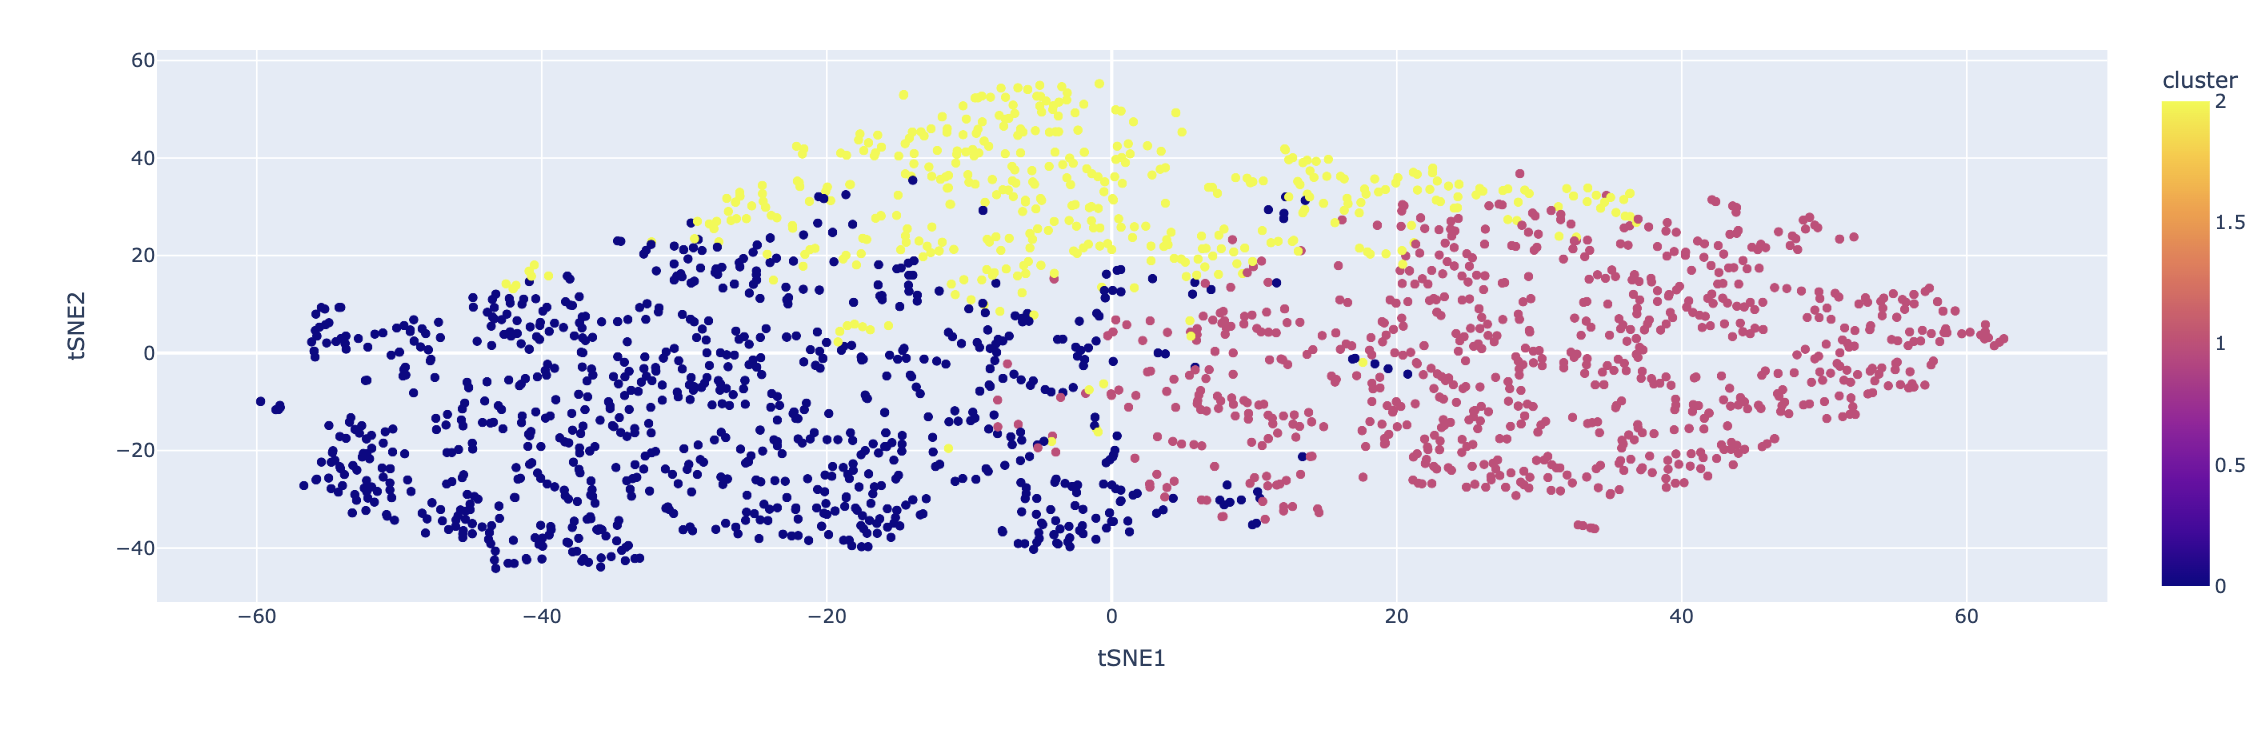

In [13]:
cluster_profile = tsne_df.groupby('cluster')[features].mean().round(2)
print("Average feature values in each cluster:")
display(cluster_profile)


Середні значення ознак у кожному кластері:


,Income,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
cluster,,,,,,,
0,33061.01,48.51,3.18,1.81,312.30,41.92,6.51
1,72551.55,49.35,8.34,1.44,315.25,47.35,3.07
2,51937.72,50.01,6.70,5.00,510.01,48.23,6.87


**t-SNE revealed three distinct groups of customers: wealthy offline shoppers, active online users who take advantage of discounts, and less affluent but engaged customers. These insights can be used to personalize marketing campaigns:**

* Cluster 0 — a premium segment, where offline offers should be prioritized.

* Cluster 1 — focus on online communication with attractive deals.

* Cluster 2 — encourage repeat purchases through bonuses and personalized discounts.